### Imports

In [28]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pickle

import tempfile
from tensorflow.keras.models import Model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def read_df_and_display_num_rows_columns(filepath):
    with open(filepath, "rb") as file:
      data = pickle.load(file)
    print(f"Reading file: {filepath}")
    print(f"number of rows: {data.shape[0]}")
    print(f"number of columns: {data.shape[1]}")
    return data

In [3]:
df_train = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/train.pickle")
df_val = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/validation.pickle")
df_test = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/test.pickle")

Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/train.pickle
number of rows: 549350
number of columns: 6
Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/validation.pickle
number of rows: 9842
number of columns: 6
Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/test.pickle
number of rows: 9824
number of columns: 6


In [4]:
df_train.head()

,premise,hypothesis,label,premise_embedded,hypothesis_embedded,cosine_score
0,person horse jumps broken airplane,person training horse competition,neutral,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.050083168, 0.020744428, 0.006436512, -0.00...",0.387597
1,person horse jumps broken airplane,person diner ordering omelette,contradiction,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[0.01991658, 0.08336658, 0.05666334, -0.005686...",0.048144
2,person horse jumps broken airplane,person outdoors horse,entailment,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.015296373, 0.051944993, 0.06472147, -0.013...",0.514768
3,children smiling waving camera,smiling parents,neutral,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.038321618, 0.09435368, 0.0064652245, 0.039...",0.594589
4,children smiling waving camera,children present,entailment,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.018334052, 0.032883544, -0.014544778, 0.03...",0.569901


In [23]:
output_dimension = 384
lstm_units = 128
trainable = False #we do not want weights of the embedding layer to be updated during the training process
hidden_size = 128

In [21]:
# Parameters
L2 = 4e-6
DROPOUT = 0.2
LEARNING_RATE = 0.01
RHO = 0.9
EPSILON = 1e-08
DECAY = 0.0

CATEGORIES = 3
BATCH_SIZE = 512
TRAINING_EPOCHS = 25

PATIENCE = 5

In [7]:
def preprocess_data_for_nli(df):
    # Define MAX_SEQ_LEN and NUM_CLASSES
    processed_data = []

    label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    # Replace string labels with numerical labels
    df['label'] = df['label'].replace(label_map)
    
    for index, row in df.iterrows():
        # Get label, premise, and hypothesis from the row
        label = row['label']
        premise = row['premise_embedded']
        hypothesis = row['hypothesis_embedded']
        
        label_new = to_categorical(label, num_classes=3)
        
        # Append the processed data as a tuple to the list
        processed_data.append((premise, hypothesis, label_new))
    
    return pd.DataFrame(processed_data, columns=['premise', 'hypothesis', 'label'])

In [8]:
df_train_copy = df_train.copy()
processed_train_data = preprocess_data_for_nli(df_train_copy)
processed_train_data.head()

,premise,hypothesis,label
0,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.050083168, 0.020744428, 0.006436512, -0.00...","[0.0, 1.0, 0.0]"
1,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[0.01991658, 0.08336658, 0.05666334, -0.005686...","[1.0, 0.0, 0.0]"
2,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.015296373, 0.051944993, 0.06472147, -0.013...","[0.0, 0.0, 1.0]"
3,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.038321618, 0.09435368, 0.0064652245, 0.039...","[0.0, 1.0, 0.0]"
4,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.018334052, 0.032883544, -0.014544778, 0.03...","[0.0, 0.0, 1.0]"


In [9]:
data_val_copy = df_val.copy()
processed_val_data = preprocess_data_for_nli(data_val_copy)
processed_val_data.head()

,premise,hypothesis,label
0,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[0.024690624, 0.09049612, 0.030129503, -0.0052...","[0.0, 1.0, 0.0]"
1,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[-0.07236776, -0.020317988, -0.034565713, 0.02...","[0.0, 0.0, 1.0]"
2,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[0.035375293, 0.042607836, -0.0109004835, 0.00...","[1.0, 0.0, 0.0]"
3,"[-0.08395465, 0.033306517, 0.05497519, -0.0349...","[-0.085580505, 0.06142286, 0.04118396, -0.0191...","[0.0, 0.0, 1.0]"
4,"[-0.08395465, 0.033306517, 0.05497519, -0.0349...","[-0.035818074, 0.0477772, 0.06401619, -0.03154...","[0.0, 1.0, 0.0]"


In [24]:
def BL_model_train(train_data):
    
    BiLSTM = Bidirectional(LSTM(lstm_units))
    translation = TimeDistributed(Dense(output_dimension, activation='relu'))
    
    premise = Input(shape=(384,), dtype='float32')
    hypothesis = Input(shape=(384,), dtype='float32')

    premise_reshaped = Reshape((1, 384))(premise)
    hypothesis_reshaped = Reshape((1, 384))(hypothesis)

    premise_timeDistributed = translation(premise_reshaped)
    hypothesis_timeDistributed = translation(hypothesis_reshaped)
    
    premise_BiLSTM = BiLSTM(premise_timeDistributed)
    hypothesis_BiLSTM = BiLSTM(hypothesis_timeDistributed)
    
    premise_normalized = BatchNormalization()(premise_BiLSTM)
    hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)
    
    train_input = concatenate([premise_normalized, hypothesis_normalized])
    train_input = Dropout(0.2)(train_input)
    
    for _ in range(3):
        train_input = Dense(2 * hidden_size, activation='relu', kernel_regularizer=l2(4e-6))(train_input)
        train_input = Dropout(0.2)(train_input)
        train_input = BatchNormalization()(train_input)
  
    prediction = Dense(3, activation='softmax')(train_input)
    
    model = Model(inputs=[premise, hypothesis], outputs=prediction)
    optimizer = Adam(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model


In [10]:
from tensorflow.keras.layers import Reshape

def BL_model_train(train_data):
    BiLSTM = Bidirectional(LSTM(lstm_units))
    translation = TimeDistributed(Dense(output_dimension, activation='relu'))
    
    premise = Input(shape=(384,), dtype='float32')
    hypothesis = Input(shape=(384,), dtype='float32')

    premise_reshaped = Reshape((1, 384))(premise)
    hypothesis_reshaped = Reshape((1, 384))(hypothesis)

    premise_timeDistributed = translation(premise_reshaped)
    hypothesis_timeDistributed = translation(hypothesis_reshaped)
    
    premise_BiLSTM = BiLSTM(premise_timeDistributed)
    hypothesis_BiLSTM = BiLSTM(hypothesis_timeDistributed)
    
    premise_normalized = BatchNormalization()(premise_BiLSTM)
    hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)
    
    train_input = concatenate([premise_normalized, hypothesis_normalized])
    train_input = Dropout(0.2)(train_input)
    
    for i in range(3):
        train_input = Dense(2 * hidden_size, activation='relu', kernel_regularizer=l2(4e-6))(train_input)
        train_input = Dropout(0.2)(train_input)
        train_input = BatchNormalization()(train_input)
  
    prediction = Dense(3, activation='softmax')(train_input)
    
    model = Model(inputs=[premise, hypothesis], outputs=prediction)
    optimizer = Adam(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model


In [11]:
import tensorflow as tf
tensor_premise = tf.convert_to_tensor(tf.constant(processed_train_data['premise'].tolist()))
tensor_hypothesis = tf.convert_to_tensor(tf.constant(processed_train_data['hypothesis'].tolist()))
tensor_label = tf.convert_to_tensor(tf.constant(processed_train_data['label'].tolist()))

In [12]:
val_premise = tf.convert_to_tensor(tf.constant(processed_val_data['premise'].tolist()))
val_hypothesis = tf.convert_to_tensor(tf.constant(processed_val_data['hypothesis'].tolist()))
val_label = tf.convert_to_tensor(tf.constant(processed_val_data['label'].tolist()))

In [25]:
print("Training model")

model = BL_model_train(processed_train_data)
    # ReduceLROnPlateau callback to reduce learning rate when the validation accuracy plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=PATIENCE, verbose=1, factor=0.5, min_lr=0.00001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)
# callbacks = [early_stopping, model_checkpoint, learning_rate_reduction]
callbacks = [model_checkpoint, learning_rate_reduction]
# Train model
history = model.fit(x=[tensor_premise, tensor_hypothesis], y=tensor_label, batch_size=BATCH_SIZE, epochs=TRAINING_EPOCHS, validation_data=([val_premise, val_hypothesis], val_label), callbacks=callbacks)
# Restore the best found model during validation
model.load_weights(tmpfn)

Training model
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 384)]        0           []                               
                                                                                                  
 reshape_8 (Reshape)            (None, 1, 384)       0           ['input_9[0][0]']                
                                                                                                  
 reshape_9 (Reshape)            (None, 1, 384)       0           ['input_10[0][0]']               
                                                                             

In [17]:
def plot_model_training(hist):
  """Function to plot accuracy and loss for iterations for the training and validation data set of the model
     Args:
       model: trained model"""
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  # Plot accuracy
  ax1.plot(hist.history['accuracy'])
  ax1.plot(hist.history['val_accuracy'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], loc='upper right')

  # Plot loss
  ax2.plot(hist.history['loss'])
  ax2.plot(hist.history['val_loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'], loc='upper right')

  plt.show()

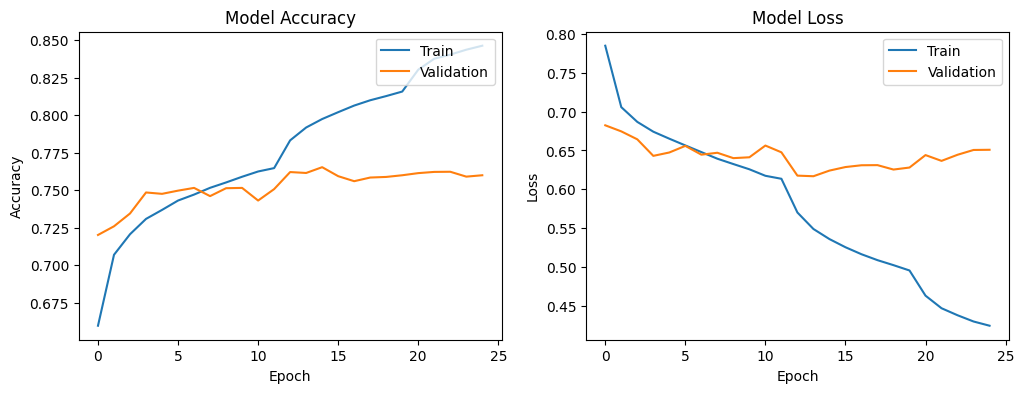

In [26]:
plot_model_training(history)

In [27]:
# Save the model as h5 file
model.save("/content/drive/MyDrive/ml-project-data-try/trained-models/BiLSTM/NLI-BiLSTM.h5")